In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
from ast import literal_eval
import seaborn as sns
import decimal

In [17]:
import sys  
sys.path.insert(0, '../../scripts')

from D_plot_specificity_matrix_utils import (peptide_per_clonotype_by_gem_size,
                                             multiple_peptides_per_gem_w_filtering,
                                             calc_binding_concordance,
                                             epitope_sorter_index,
                                             peptides_per_gem)

In [18]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

In [19]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [20]:
def notnan(x):
    return x == x

In [21]:
def get_multiplets(df):
    #tmp = df[idx1 & idx2]
    dct = df.groupby(['ct','peptide_HLA']).gem.count() > 1
    idx = df.set_index(['ct','peptide_HLA']).index.map(dct)
    return idx.fillna(False)

In [143]:
def plot_specificity(title, df, max_gems, save=True):
    # Define order for peptides
    rank = {'GILGFVFTL A0201':1,'GLCTLVAML A0201':2,'NLVPMVATV A0201':3,'CLGGLLTMV A0201':4,
            'FLYALALLL A0201':5,'VLEETSVML A0201':6,'YVLDHLIVV A0201':7,
            'RVRAYTYSK A0301':8,'RPHERNGFTV B0702':9,'RPHERNGFTVL B0702':10,
            'RPPIFIRRL B0702':11,'TPRVTGGGAM B0702':12,'TPSVSSSISSL B0702':13}
    df['rank'] = df.peptide_HLA.map(rank)

    # Sort
    df.ct = df.ct.astype(int).astype(str)
    df.sort_values(by=['rank','gems_per_specificity','binding_concordance'], #,'ct'
                       ascending=[True, False, False], inplace=True) #, True

    # devide GEMs by max concordance and outliers
    dct = df.groupby('ct').binding_concordance.max()
    df['max_conc'] = df.ct.map(dct)
    idx = df.binding_concordance == df.max_conc

    def modify_legend(h,l):
        flag = False
        labels = []
        handles = []
        for e, le in enumerate(l):
            if flag:
                #if (int(le) % 10 == 0) | (le == '1'):
                labels.append(le)
                handles.append(h[e])
            if le == 'gems_per_specificity':
                flag = True
        n = int(len(labels)/2)
        h = [handles[0]] + [handles[n]] + [handles[-1]]
        l = [labels[0]] + [labels[n]] + [labels[-1]]
        return h, l
    
    # Style
    # https://seaborn.pydata.org/generated/seaborn.axes_style.html
    sns.set_style('ticks', {'axes.edgecolor': '0', #'axes.facecolor':'lightgrey',
                            'xtick.color': '0',
                            'ytick.color': '0'})
    sns.set_context("paper",font_scale=2)
    
    f_pep = df.peptide_HLA.nunique() / len(rank)
    fig = plt.figure(figsize=(20,6*f_pep))
    sns.scatterplot(data=df[idx], x='ct', y='peptide_HLA',
                    size='gems_per_specificity', sizes=(10,1000), size_norm=(1,max_gems),
                    hue='binding_concordance', palette='viridis_r', hue_norm=(0,1),
                    legend='full', linewidth=0)
    sns.scatterplot(data=df[~idx], x='ct', y='peptide_HLA',
                    size='gems_per_specificity', sizes=(10,1000), size_norm=(1,max_gems),
                    hue='binding_concordance', palette='viridis_r', hue_norm=(0,1),
                    legend=False, linewidth=0)
    ax = plt.gca()
    sm = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap='viridis_r') # hack for cbar
    sm.set_array([]) # hack for cbar
    #fig.colorbar(sm, ax=ax, pad=0.01)
    if '10' in title:
        fig.colorbar(sm, ax=ax, orientation='horizontal', label='Binding Concordance', fraction=0.06) #https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.colorbar.html

    h,l = ax.get_legend_handles_labels()
    h,l = modify_legend(h,l)
    ax.legend(h, l, bbox_to_anchor=(0.5, -0.5), loc=9, frameon=False, title='GEMs', ncol=len(l))

    #plt.title('%d clonotypes (%d GEMs)' %(df.ct.nunique(), df.gem.nunique()))
    plt.xlabel('%d clonotypes (across %d GEMs)' %(df.ct.nunique(), df.gem.nunique()))
    #plt.xlabel('')
    plt.ylabel('')

    sns.despine(bottom=False, trim=True, offset={'left':-30})
    #ax.set_xticks([])
    #ax.set_xticklabels()
    plt.xticks(rotation=90)
    if save:
        plt.savefig(title, bbox_inches='tight', dpi=300)
    plt.show()

# Input

In [51]:
OPT_THR = '../../experiments/exp13/run1/cat/eval_clonotypes/threshold/opt.csv'

In [52]:
VALID = '../../experiments/exp13/run1/cat/eval_clonotypes/valid_ct.csv'
#OS2 = '../experiments/exp13/run2/cat/eval_clonotypes/valid_ct.csv'

In [53]:
HTO = '../../experiments/exp13/run1/brc/outfile.csv'
GEX = '../../experiments/exp13/run1_archive/tcr/usable_gems.txt'
TCR = '../../experiments/exp13/run1/tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'
TCR_ARC = '../../experiments/exp13/run1_archive/tcr/cellranger_tot/outs/multi/vdj_t/all_contig_annotations.csv'

# Load

In [54]:
tcr = pd.read_csv(TCR)
tcr_dct = tcr.groupby('barcode').is_cell.unique().apply(lambda x: x[0])

In [55]:
tcr_arc = pd.read_csv(TCR_ARC)
arc_dct = tcr_arc.groupby('barcode').is_cell.unique().apply(lambda x: x[0])

In [56]:
tcr_cell = pd.merge(arc_dct,tcr_dct, left_index=True,right_index=True, how='outer', suffixes=['_arc','_gex'])

In [57]:
gex = pd.read_csv(GEX, header=None, names=['gem'])

In [58]:
opt_thr = pd.read_csv(OPT_THR, index_col=0, header=None, names=['thr']).thr.dropna()
opt_thr.umi_count_cd8 = 0
opt_thr.delta_umi_cd8 = 0
opt_thr

umi_count_mhc    2.000000
delta_umi_mhc    1.168364
umi_count_TRA    0.000000
delta_umi_TRA    0.000000
umi_count_TRB    0.000000
delta_umi_TRB    0.000000
Name: thr, dtype: float64

In [71]:
df = pd.read_csv(VALID, converters=converters)

In [72]:
df.fillna({'umi_count_mhc':0, 'delta_umi_mhc':0, 'umi_count_mhc_rel':0,
           'umi_count_cd8':0, 'delta_umi_cd8':0,
           'umi_count_TRA':0, 'delta_umi_TRA':0,
           'umi_count_TRB':0, 'delta_umi_TRB':0,
           'cdr3_TRA':'','cdr3_TRB':''}, inplace=True)

In [61]:
hto = pd.read_csv(HTO, skiprows=1, header=None,
                  names=['gem','seurat','umi_count_hto','feature_rna','count_hto','feature_hto','hto_max_id','hto_sec_id','hto_margin','hto_classification','hto_global_class','hash_id'])

In [73]:
# df = pd.merge(os1, hto, how='left', on='gem')
# df.hto_global_class.fillna('Singlet', inplace=True)
# df['gex'] = df.gem.isin(gex.gem)
# #df['gex'] = df.gem.map(tcr_dct)
# df = pd.merge(df, tcr_cell, left_on='gem',right_index=True)

# Reduction in GEMs and CTs when filtering

In [92]:
df = calc_binding_concordance(df,'ct')

In [74]:
df.single_barcode_mhc = np.where(df.single_barcode_mhc, 'pMHC singlet','pMHC multiplet')

In [75]:
df['clonotype_multiplet'] = df.ct.map(df.groupby('ct').size() > 1)

In [76]:
idx1 = eval(' & '.join([f'(df.{k} >= {abs(v)})' for k,v in opt_thr.items()]))

idx2 = df.hto_global_class == 'Singlet'

idx3 = df.apply(lambda row: row.peptide_HLA.split()[-1] in row.HLA_cd8 if (notnan(row.peptide_HLA) & notnan(row.HLA_cd8)) else False, axis=1)

idx4 = df['exclude_single-chain_TCRs']

idx5 = get_multiplets(df)

In [79]:
#idx6 = df.is_cell_arc
#idx7 = df.is_cell_gex

In [80]:
#idx8 = df.gex

In [81]:
filterings = [idx1,
              (idx1 & idx3),
              (idx1 & idx4 & idx3)]
labels = ['optimal threshold',
          'matching HLA',
          'complete TCRs']
palette = ['grey','#ffffcc','#c7e9b4','#7fcdbb']
#palette = ['grey','#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']

In [100]:
sub_df = df[(idx1 & idx4 & idx3) & (df.label==1)].copy()

In [106]:
sub_df.sort_values(by=['peptide_HLA','ct'], ascending=[True,True], inplace=True)

1.0


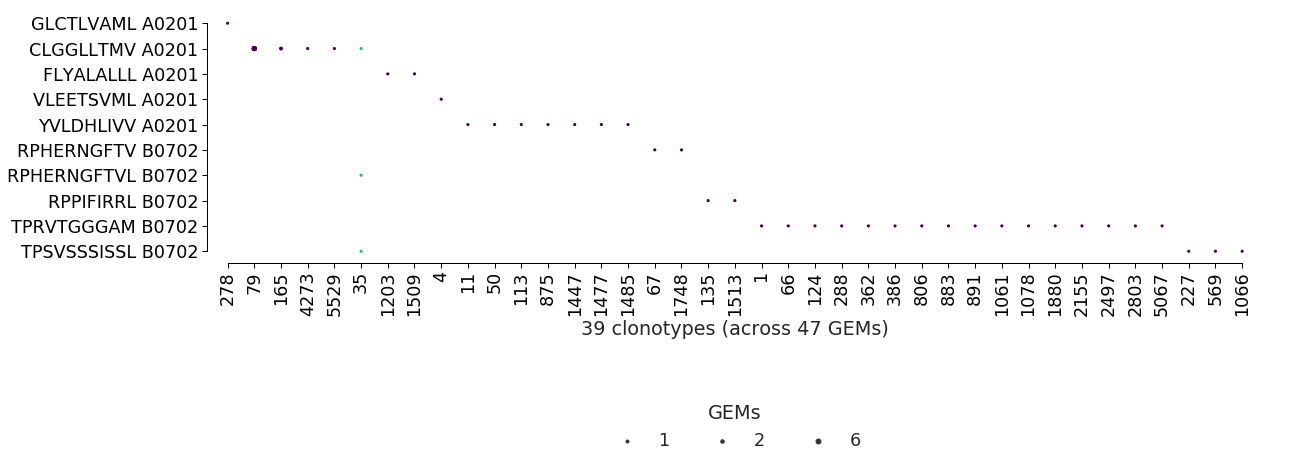

2.0


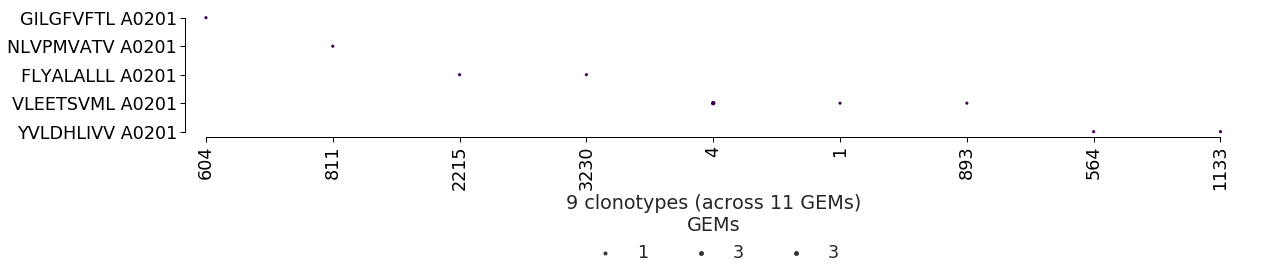

3.0


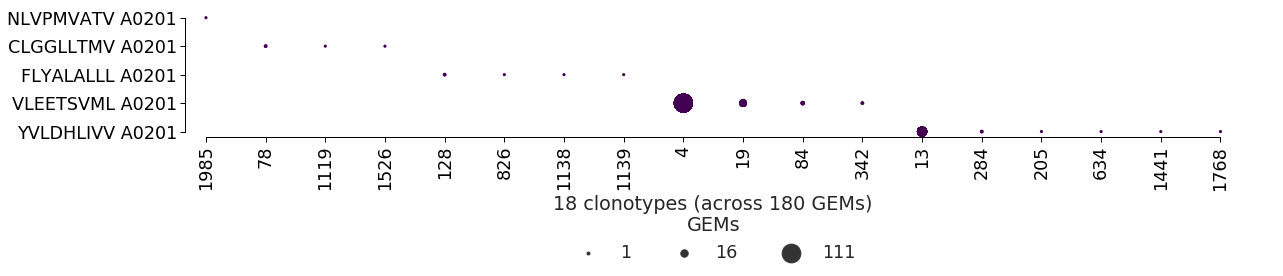

4.0


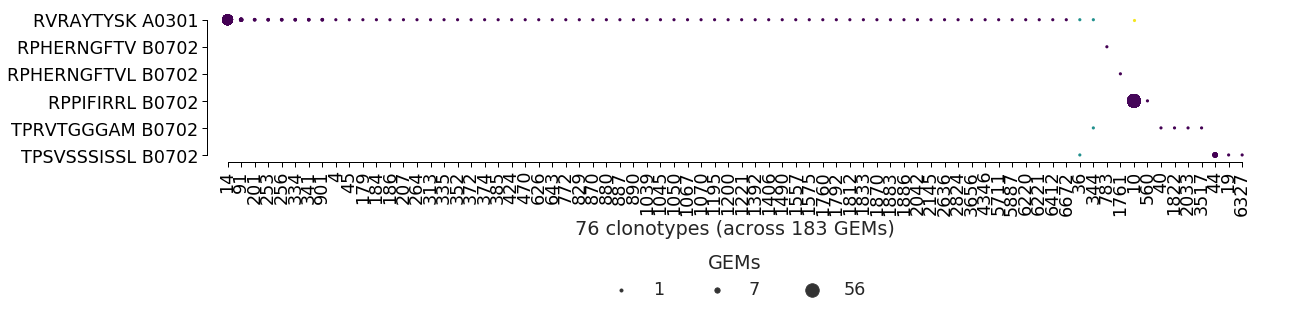

5.0


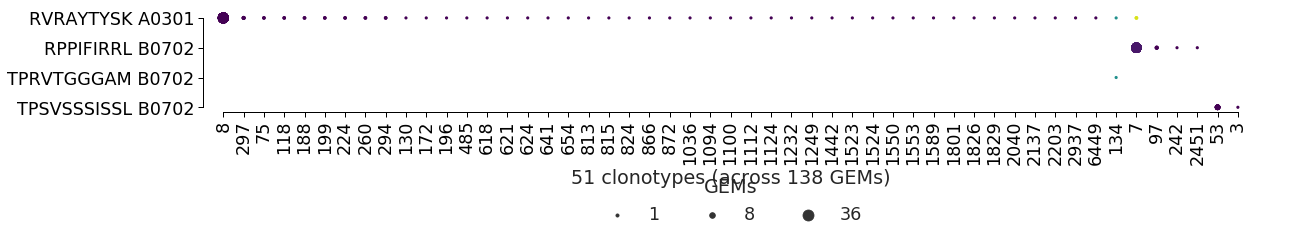

6.0


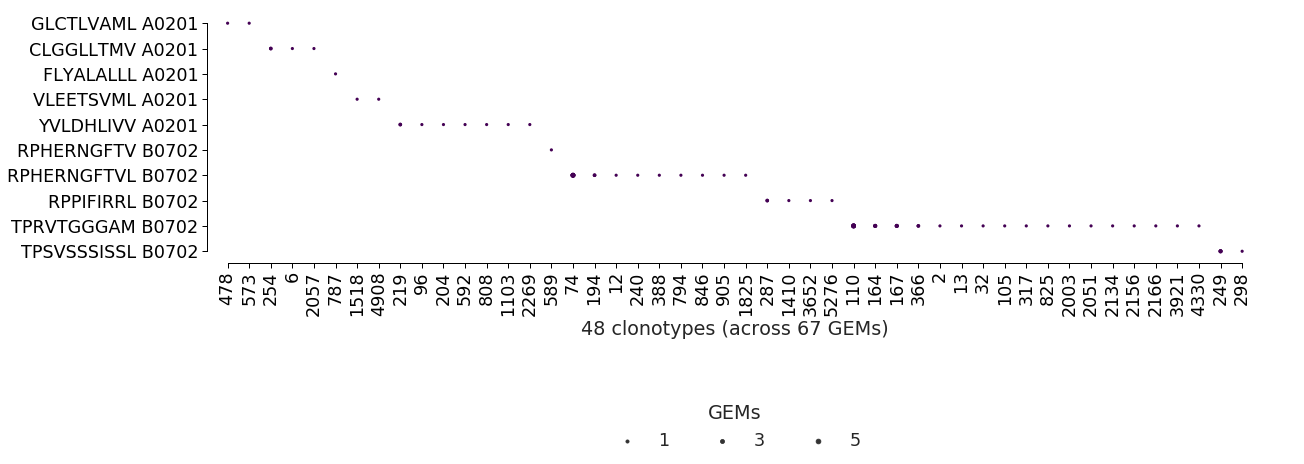

7.0


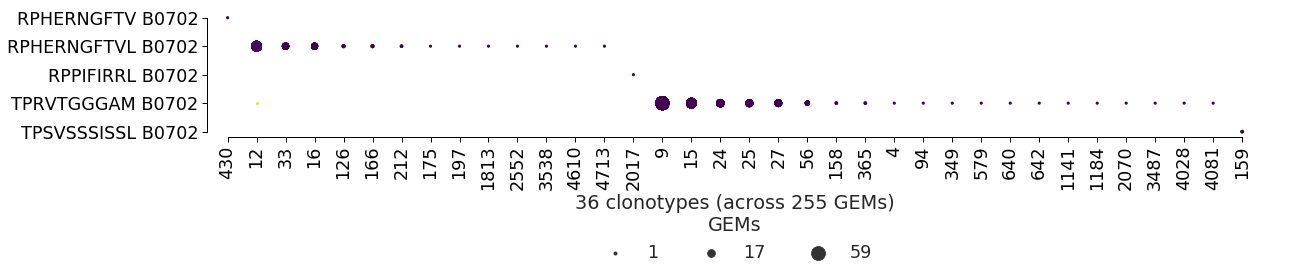

8.0


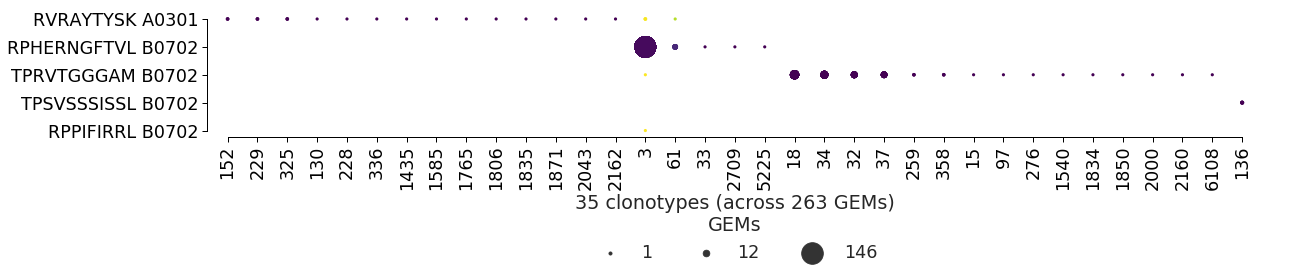

9.0


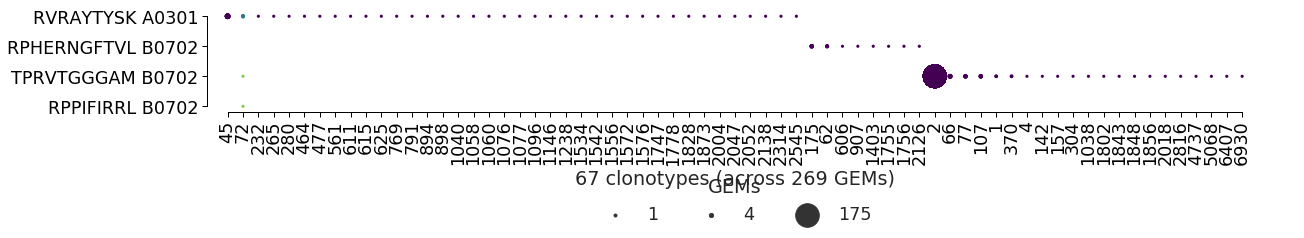

10.0


/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib/colorbar.py:214: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


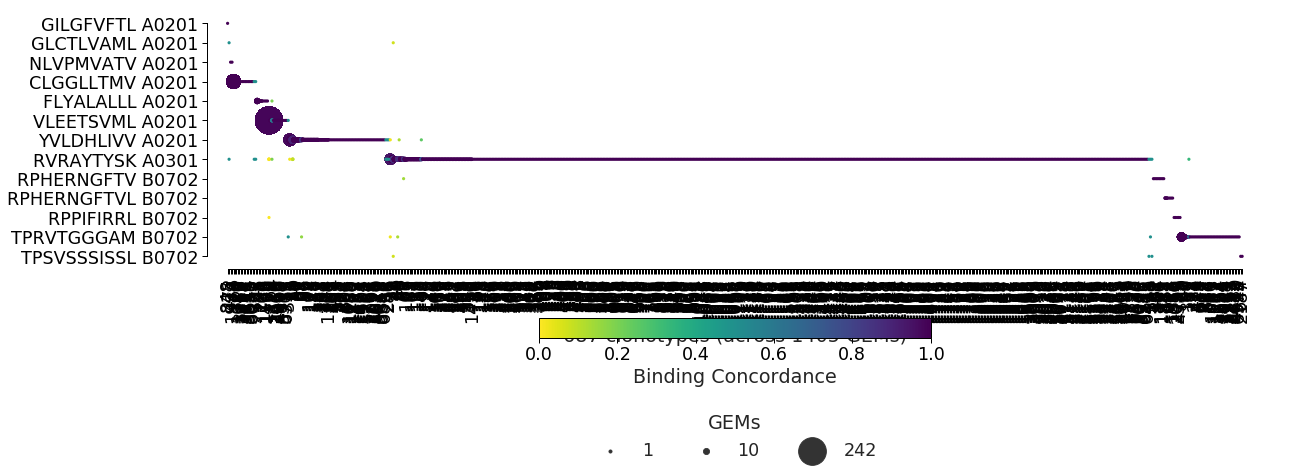

In [145]:

with pd.ExcelWriter('../tmp_files/filtered_data.xlsx') as writer:
    sub_df.to_excel(writer, sheet_name='all_samples', index=False)
    grp = sub_df.groupby('sample_id')
    for sample, g in grp:
        print(sample)
        g[['gem','ct','peptide_HLA','sample_id']].to_excel(writer, sheet_name='sample_%d' %sample, index=False)
        tmp = calc_binding_concordance(g,'ct')
        plot_specificity('../tmp_files/plot_per_sample/%d.png'%sample, tmp, df.gems_per_specificity.max(), save=True)

In [96]:
df.gems_per_specificity.max()

313

In [93]:
calc_binding_concordance(df,'ct')

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr1_TRA,...,sample_hla,pep_match,hla_match,ct_match,valid_ct,train_label,test_label,clonotype_multiplet,gems_per_spec_hla_match,hla_concordance
0,AAACCTGAGCCCAGCT-1,clonotype1825,1825.0,1825.0,TRAV8-3;TRAJ10;TRAC,TRBV6-5;;TRBJ1-2;TRBC1,['TRAV8-3;TRAJ10;TRAC'],['TRBV2;;TRBJ1-3;TRBC1' 'TRBV6-5;;TRBJ1-2;TRBC1'],684.0,YGATPY,...,NaN,NaN,NaN,NaN,False,NaN,True,False,1.0,1.000000
1,AAACCTGAGTCAATAG-1,clonotype1136,1136.0,1136.0,TRAV17;TRAJ38;TRAC,TRBV19;;TRBJ2-7;TRBC2,['TRAV17;TRAJ38;TRAC'],['TRBV19;;TRBJ2-7;TRBC2'],518.0,TSINN,...,NaN,NaN,NaN,NaN,False,NaN,True,False,1.0,1.000000
2,AAACCTGCAATCCGAT-1,clonotype3,3.0,3.0,TRAV1-1;TRAJ10;TRAC,TRBV5-1;;TRBJ2-5;TRBC2,['TRAV1-1;TRAJ10;TRAC'],['TRBV5-1;;TRBJ2-5;TRBC2'],496.0,TSGFYG,...,"['A0301', 'B0702']",True,True,True,True,True,True,True,171.0,1.000000
3,AAACCTGCAGCCAGAA-1,clonotype79,79.0,79.0,TRAV21;TRAJ33;TRAC,TRBV10-2;;TRBJ1-1;TRBC1,['TRAV21;TRAJ33;TRAC'],['TRBV10-2;;TRBJ1-1;TRBC1'],472.0,DSAIYN,...,NaN,NaN,NaN,NaN,False,NaN,True,True,6.0,1.000000
4,AAACCTGCATGCCACG-1,clonotype15,15.0,15.0,TRAV17;TRAJ12;TRAC,TRBV7-9;;TRBJ2-1;TRBC2,['TRAV17;TRAJ12;TRAC'],['TRBV7-9;;TRBJ2-1;TRBC2'],589.0,TSINN,...,['B0702'],True,True,True,True,True,True,True,35.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7120,TTTGGTTGTTGAGGTG-1,clonotype5,5.0,5.0,NaN,TRBV28;;TRBJ2-7;TRBC2,NaN,['TRBV28;;TRBJ2-7;TRBC2'],NaN,NaN,...,"['A0201', 'A0301', 'B0702']",True,True,True,True,True,True,True,123.0,0.991935
7121,TTTGTCAAGAATGTTG-1,NaN,0.0,3579.0,NaN,TRBV6-1;;TRBJ2-7;TRBC2,NaN,['TRBV6-1;;TRBJ2-7;TRBC2'],NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,True,False,1.0,1.000000
7122,TTTGTCAAGCGTGAAC-1,NaN,0.0,6790.0,NaN,TRBV20-1;;TRBJ2-1;TRBC2,NaN,['TRBV20-1;;TRBJ2-1;TRBC2'],NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,True,False,1.0,1.000000
7123,TTTGTCATCACCTCGT-1,clonotype233,233.0,233.0,NaN,TRBV19;TRBD1;TRBJ1-5;TRBC1,NaN,['TRBV19;TRBD1;TRBJ1-5;TRBC1'],NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,False,True,NaN,0.000000
